# ARIMA Model

## Imports

In [1]:
import pandas as pd
import numpy as np
import json
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error

## File Extraction - Amazon Data

In [2]:
ticker = 'JNJ'

In [3]:
file_path = f'../DataInputs/Weekly-Closing-Prices/{ticker}_Pricing/{ticker}_weekly_close.json' # path of json file

# Load JSON data from file
with open(file_path, 'r') as file:
    data = json.load(file)

# Convert data to pandas DataFrame
df = pd.DataFrame(list(data.items()), columns=['Date', 'Close'])
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = df['Close'].astype(float)
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)


## Splitting Dataset - Training & Test

- train_df, used for training the ARIMA model
- test_df, used for comparing the prediction the model makes to the values in test df

In [4]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd

# Your initial data frame df needs to be defined earlier in your code


In [5]:

# Covid - 2020-03-13	2019-07-12 - April Stable	Drop -  2022-04-08

# Given date
date_str = '2020-03-13'
date_format = "%Y-%m-%d"
date = datetime.strptime(date_str, date_format)

# Calculate date + 3 months dynamically
date_plus_3_months = date + relativedelta(months=+3)

date_minus_3_months = date + relativedelta(months=-3)

# Convert the end date back to string for filtering
date_plus_3_months_str = date_plus_3_months.strftime(date_format)

date_minus_3_months_str = date_minus_3_months.strftime(date_format)


In [6]:

# Split the data
train_df = df[df.index <= date_str]
test_df = df[(df.index > date_str) & (df.index <= date_plus_3_months_str)]

# Check the last date in the training set and the first date in the test set
print("Last date in training set:", train_df.index[-1])
print("First date in test set:", test_df.index[0])

# Check the last few rows of the training set
print(train_df.tail())

# The training data set is now the main dataframe
df = train_df.copy()

# Check the first few rows of the test set
print(test_df.tail())


Last date in training set: 2020-03-13 00:00:00
First date in test set: 2020-03-20 00:00:00
               Close
Date                
2020-02-14  133.8059
2020-02-21  133.6276
2020-02-28  120.6379
2020-03-06  127.4108
2020-03-13  120.4675
               Close
Date                
2020-05-15  134.9552
2020-05-22  130.4160
2020-05-29  134.3726
2020-06-05  133.0628
2020-06-12  128.4106


## Training Dataset Graph

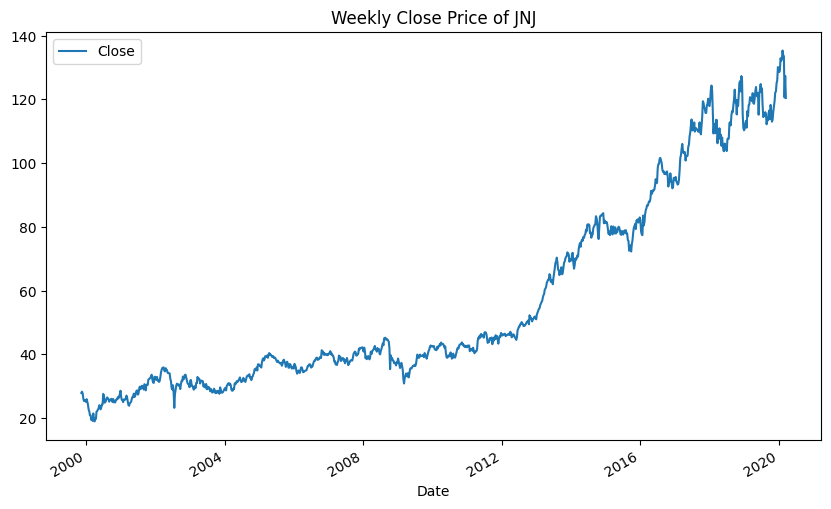

In [7]:
df.plot(figsize=(10,6))
plt.title(f'Weekly Close Price of {ticker}')
plt.show()

## Checking Stationarity 

In [8]:
result = adfuller(df['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.711421
p-value: 0.990063


## Differencing 

This makes the dataset stationary

In [9]:
# Assuming the series is not stationary, differencing is needed
df_diff = df.diff().dropna()

# Check stationarity again
result = adfuller(df_diff['Close'])
print('p-value after differencing: %f' % result[1])


p-value after differencing: 0.000000


## ACF & PACF

ACF and PACF plots are crucial for determining the parameters (p, d, q) for ARIMA models. The p and q parameters can be estimated from PACF and ACF plots, respectively.


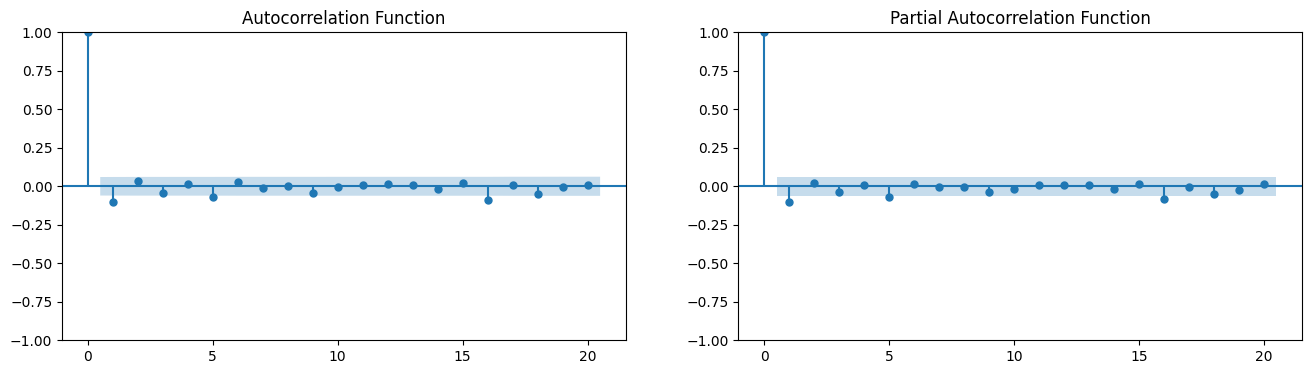

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# ACF
plot_acf(df_diff['Close'], ax=ax1, lags=20)
ax1.set_title('Autocorrelation Function')

# PACF
plot_pacf(df_diff['Close'], ax=ax2, lags=20)
ax2.set_title('Partial Autocorrelation Function')

plt.show()


## Making the ARIMA Model - p, d, q selection

In [11]:
# Assuming 'df' is your DataFrame and it's indexed by date
start_date = df.index.min()  # or replace with the specific start date string

# Set the frequency to weekly, starting on the start_date
df.index = pd.date_range(start=start_date, periods=len(df), freq='W-FRI')

# Replace p, d, q with your chosen values
model = ARIMA(df['Close'], order=(3,2,1))

results = model.fit()

# Summary of the model
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1062
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -1927.115
Date:                Sat, 27 Apr 2024   AIC                           3864.229
Time:                        16:33:22   BIC                           3889.059
Sample:                    11-12-1999   HQIC                          3873.640
                         - 03-13-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1011      0.016     -6.372      0.000      -0.132      -0.070
ar.L2          0.0247      0.018      1.335      0.182      -0.012       0.061
ar.L3         -0.0470      0.022     -2.123      0.0

## Model Diagnostics

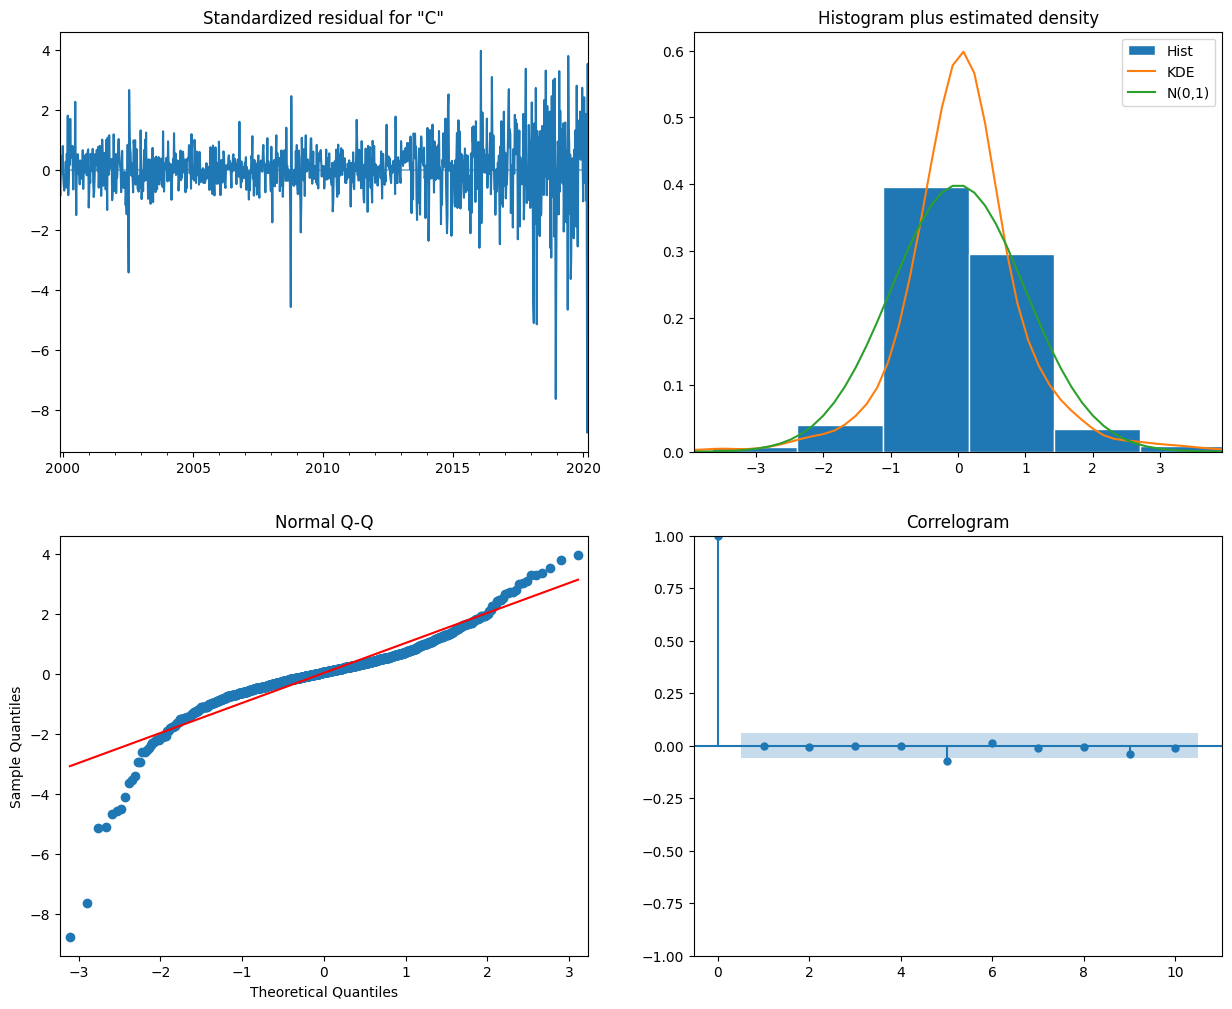

In [12]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


## Prediction Graph

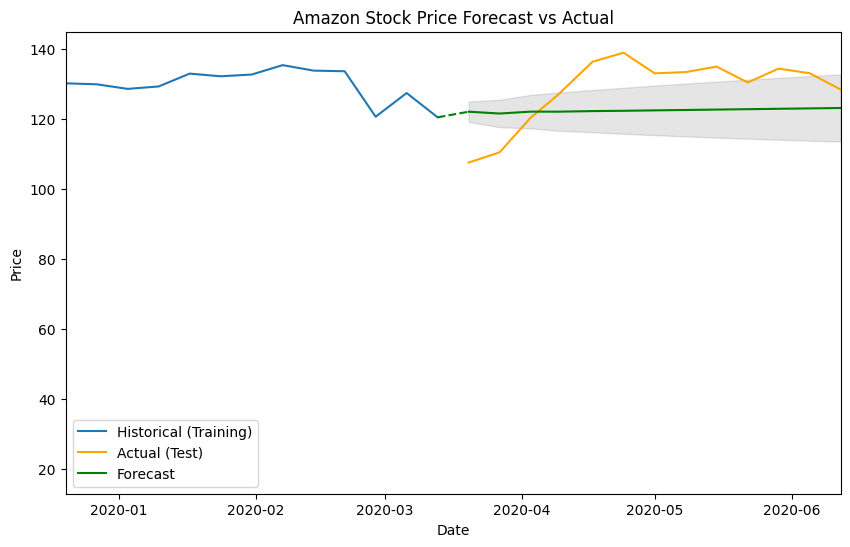

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import pandas as pd

# Assuming 'results', 'train_df', and 'test_df' are already defined and prepared in your code

# Number of steps to forecast is the length of the test set
n_steps = len(test_df)

# Generate out-of-sample forecasts
forecast = results.get_forecast(steps=n_steps)
forecast_index = test_df.index  # Use the test set dates for the forecast index

# Confidence intervals
forecast_ci = forecast.conf_int()

# Plotting the forecast along with the test set
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['Close'], label='Historical (Training)')

# ADD THIS LINE TO CONNECT THE LAST TRAINING POINT TO THE FIRST FORECAST POINT
if not train_df['Close'].empty and not forecast.predicted_mean.empty:
    last_train_point = (train_df.index[-1], train_df['Close'].iloc[-1])
    first_forecast_point = (forecast_index[0], forecast.predicted_mean.iloc[0])
    plt.plot([last_train_point[0], first_forecast_point[0]], [last_train_point[1], first_forecast_point[1]], color='green', linestyle='--')

plt.plot(test_df.index, test_df['Close'], label='Actual (Test)', color='orange')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='green')
plt.fill_between(forecast_index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], color='k', alpha=0.1)

# Dynamically set the xlim to focus on the last 3 months of the training data and the prediction period
three_months_before_test_start = test_df.index[0] - relativedelta(months=3)
plt.xlim([three_months_before_test_start, test_df.index[-1]])

# Set the format of the x-axis to better display the dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.title('Amazon Stock Price Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


## RMSE & MAE

In [14]:
predicted_values = forecast.predicted_mean
actual_values = test_df['Close']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("Root Mean Squared Error: ", rmse)

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)
print("Mean Absolute Error: ", mae)


Root Mean Squared Error:  10.850503583942295
Mean Absolute Error:  10.057280398190468


## Optimising

In [15]:
import pmdarima as pm

# Using auto_arima to find the best ARIMA model with a wider range of parameters
best_model = pm.auto_arima(train_df['Close'],
                           seasonal=True,  # assuming the data could be seasonal
                           m=1,           # weekly data, so m might be 52 for yearly seasonality
                           stepwise=True,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           max_p=5, max_q=5, max_d=2,
                           max_P=2, max_Q=2, max_D=1)

print(best_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3853.762, Time=1.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3867.749, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3858.671, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3859.240, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3869.358, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3857.783, Time=0.87 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3857.846, Time=0.70 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3855.762, Time=1.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3855.762, Time=2.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3856.540, Time=0.58 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3858.891, Time=1.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3859.012, Time=1.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3847.729, Time=3.43 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3849.493, Time=3.46 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept

## Optimised Graph

c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


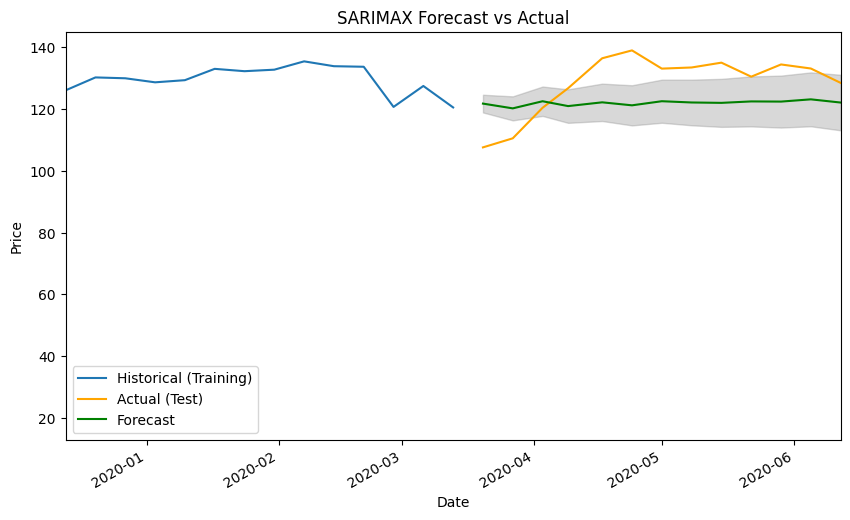

In [16]:
# Forecast with the best SARIMAX model
n_periods = len(test_df)
forecast, conf_int = best_model.predict(n_periods=n_periods, return_conf_int=True)

# Plot the forecast with confidence intervals
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['Close'], label='Historical (Training)')
plt.plot(test_df.index, test_df['Close'], label='Actual (Test)', color='orange')
plt.plot(test_df.index, forecast, label='Forecast', color='green')
plt.fill_between(test_df.index, 
                 conf_int[:, 0], 
                 conf_int[:, 1], color='grey', alpha=0.3)


plt.xlim([pd.Timestamp(date_minus_3_months_str), test_df.index[-1]])

# (Optional) Set the format of the x-axis to better display the dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.title('SARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate the date labels for better readability
plt.gcf().autofmt_xdate()

plt.show()


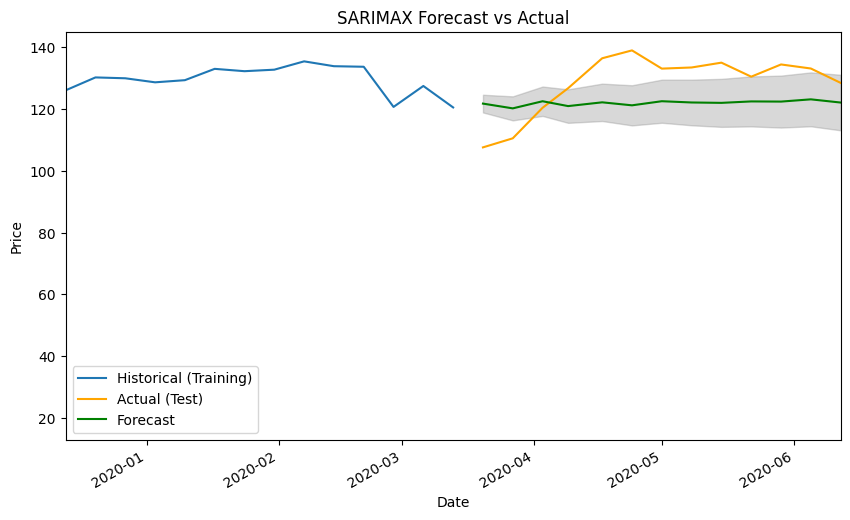

In [17]:
import matplotlib.dates as mdates

# Plot the forecast with confidence intervals
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['Close'], label='Historical (Training)')
plt.plot(test_df.index, test_df['Close'], label='Actual (Test)', color='orange')
plt.plot(test_df.index, forecast, label='Forecast', color='green')
plt.fill_between(test_df.index, 
                 conf_int[:, 0], 
                 conf_int[:, 1], color='grey', alpha=0.3)


plt.xlim([pd.Timestamp(date_minus_3_months_str), test_df.index[-1]])

# (Optional) Set the format of the x-axis to better display the dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.title('SARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate the date labels for better readability
plt.gcf().autofmt_xdate()

plt.show()


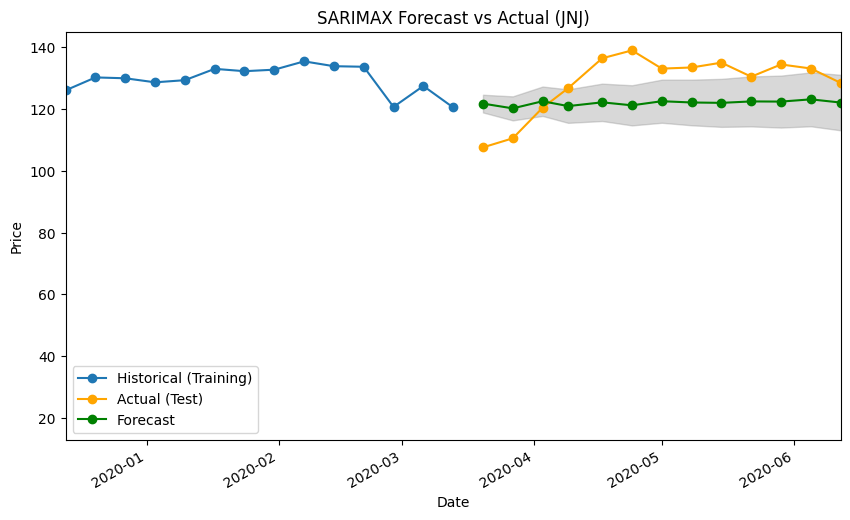

In [18]:

import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt

# Your data setup code should go here
# Make sure train_df, test_df, forecast, and conf_int are defined

plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['Close'], 'o-', label='Historical (Training)') # Added 'o-' for dots and lines
plt.plot(test_df.index, test_df['Close'], 'o-', label='Actual (Test)', color='orange') # Added 'o-' for dots and lines
plt.plot(test_df.index, forecast, 'o-', label='Forecast', color='green') # Added 'o-' for dots and lines
plt.fill_between(test_df.index, 
                 conf_int[:, 0], 
                 conf_int[:, 1], color='grey', alpha=0.3)

plt.xlim([pd.Timestamp(date_minus_3_months_str), test_df.index[-1]])

# Optional: Set the format of the x-axis to better display the dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.title(f'SARIMAX Forecast vs Actual ({ticker})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate the date labels for better readability
plt.gcf().autofmt_xdate()

plt.show()


## Optimised RSME & MAE

In [19]:
# Generating the forecast for the entire duration of the test set
forecast, conf_int = best_model.predict(n_periods=n_steps, return_conf_int=True)

# Make sure the forecast_index aligns with the forecast length
# This should be equivalent to the test set index length
forecast_index = test_df.index

# Now the predicted_values should have the same length as the actual_values
predicted_values = forecast

# Actual values from the test set
actual_values = test_df['Close']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("Root Mean Squared Error: ", rmse)

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)
print("Mean Absolute Error: ", mae)


Root Mean Squared Error:  11.12138491495653
Mean Absolute Error:  10.383695799618412


c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


saving JSON

In [20]:
import os
import json

# Assuming 'predicted_values' contain your ARIMA model forecasts and 'forecast_index' contains the corresponding dates

# Convert forecast dates to string format if not already
forecast_dates_str = [date.strftime('%Y-%m-%d') for date in forecast_index]

# Prepare your predictions dictionary
predictions_dict = dict(zip(forecast_dates_str, predicted_values.tolist()))

# Define the directory and file path for saving the predictions
event = 'covid'  # or 'stable' or 'drop' depending on the scenario you're analyzing
output_dir = f'../outputs/{ticker}/{event}'
output_file = f'ARIMA_prediction.json'
output_path = os.path.join(output_dir, output_file)

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the predictions to a JSON file
# with open(output_path, 'w') as file:
#     json.dump(predictions_dict, file, indent=4)

print(f'ARIMA predictions saved successfully to {output_path}')


ARIMA predictions saved successfully to ../outputs/JNJ/covid\ARIMA_prediction.json
